In [1]:
# %pip  install scikit-image

In [2]:
# Image completion
import os
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from ipywidgets import interact, widgets

if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
# Read in a image from torchvision
# img = torchvision.io.read_image("dog.jpg")
img = torchvision.io.read_image("frog.jpg")
print(img.shape)

torch.Size([3, 1661, 2500])


In [5]:
# Make grayscale
img = torch.tensor(img, dtype=torch.float) 
# img = img.clone().detach()
img = img.mean(dim=0, keepdim=False)
print(img.shape)

torch.Size([1661, 2500])


C:\Users\JENIL\AppData\Local\Temp\ipykernel_5436\4232874494.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


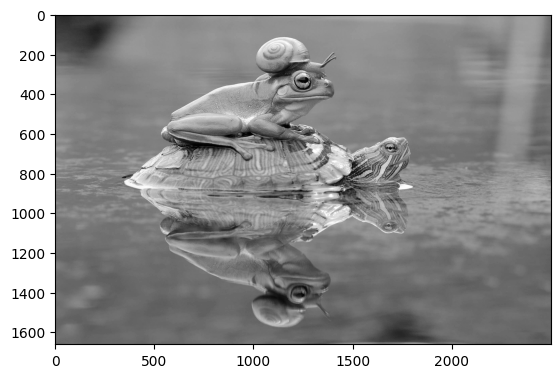

In [6]:
plt.imshow(img, cmap='gray')

In [7]:
# crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
crop = torchvision.transforms.functional.crop(img, 220, 1100, 300, 300)
crop.shape

torch.Size([300, 300])

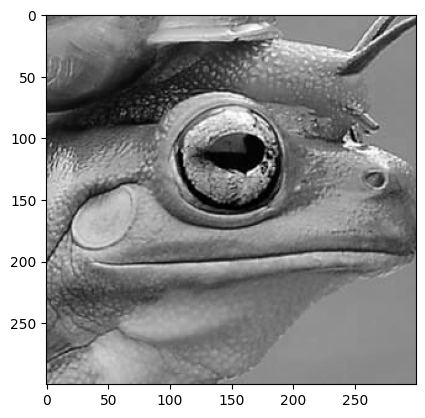

In [8]:
plt.imshow(crop, cmap='gray')

In [9]:
# Mask the image with NaN values 
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

In [10]:
masked_img = mask_image(crop, 0.15)


In [11]:
masked_img[1].sum()

tensor(13670)

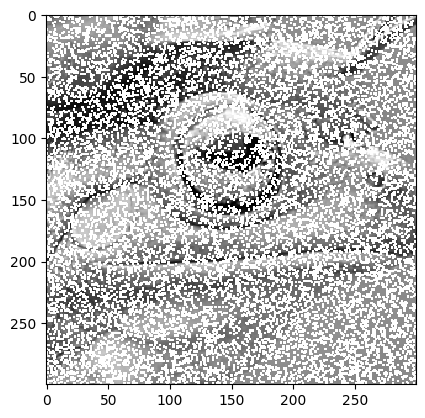

In [12]:
plt.imshow(masked_img[0], cmap='gray')

In [13]:
# Modify the loss function to ignore NaN values
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [14]:
Rank = 50

W, H, loss = factorize(masked_img[0], Rank, device=device)

print(loss)

tensor(2470.1658, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [15]:
# print(W, "\n",W.shape)
# print(H, "\n",H.shape)

Text(0.5, 1.0, 'Reconstructed Image')

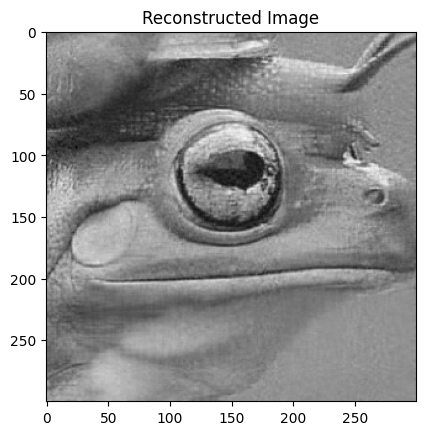

In [16]:
plt.imshow(torch.mm(W, H).cpu().detach().numpy(), cmap='gray')
plt.title("Reconstructed Image")

In [17]:
# import numpy as np
# from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

# # Function to compute RMSE (Root Mean Squared Error)
# def compute_rmse(original, reconstructed):
#     return np.sqrt(mean_squared_error(original, reconstructed))

# # Function to compute PSNR (Peak Signal-to-Noise Ratio)
# def compute_psnr(original, reconstructed):
#     return peak_signal_noise_ratio(original, reconstructed)


# original = img
# reconstructed = np.random.rand(100, 100)

# # Calculate RMSE and PSNR
# rmse_before_gd = compute_rmse(original, reconstructed)
# psnr_before_gd = compute_psnr(original, reconstructed)

# # Print the calculated metrics
# print(f"RMSE before Gradient Descent: {rmse_before_gd}")
# print(f"PSNR before Gradient Descent: {psnr_before_gd}")


RMSE for Reconstructed Image: 10.235875129699707
PSNR for Reconstructed Image: -20.202499389648438


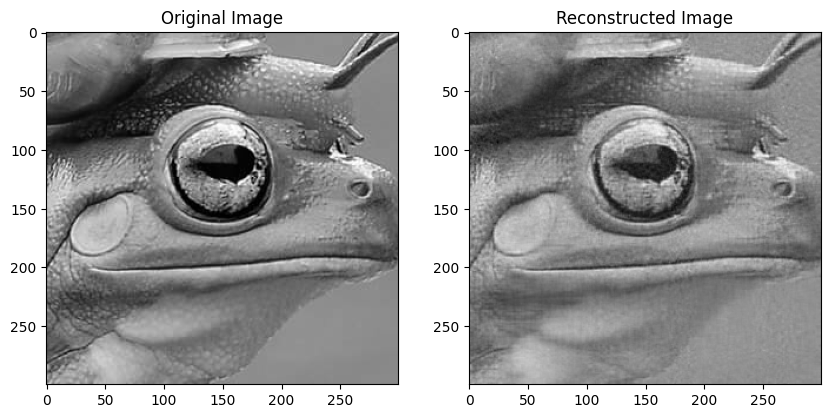

In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Function to compute RMSE (Root Mean Squared Error) for PyTorch tensors
def compute_rmse(original, reconstructed):
    mse = F.mse_loss(reconstructed, original)
    rmse = torch.sqrt(mse)
    return rmse.item()

# Function to compute PSNR (Peak Signal-to-Noise Ratio) for PyTorch tensors
def compute_psnr(original, reconstructed):
    mse = F.mse_loss(reconstructed, original)
    if mse == 0:
        return float('inf')  # If there is no difference, PSNR is infinite
    max_pixel_value = 1.0  # Assuming the images are normalized between 0 and 1
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

# Perform matrix multiplication
reconstructed = torch.mm(W, H).cpu().detach()

# Assume original is a similar-sized tensor for the comparison
original = crop  # Replace with your actual image tensor

# Calculate RMSE and PSNR
RMSE = compute_rmse(original, reconstructed)
PSNR = compute_psnr(original, reconstructed)

# Print the calculated metrics
print(f"RMSE for Reconstructed Image: {RMSE}")
print(f"PSNR for Reconstructed Image: {PSNR}")

# Visualize the reconstructed image (for example purposes)
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)  # First subplot (1 row, 2 columns, position 1)
plt.imshow(original, cmap='gray')
plt.title('Original Image')

fig.add_subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, position 2)
plt.imshow(reconstructed.cpu().detach().numpy(), cmap='gray')
plt.title('Reconstructed Image')

plt.show()


In [19]:
def plot_image_completion(prop=0.1, factors=50):
    masked_img, mask = mask_image(crop, prop)
    W, H, loss = factorize(masked_img, factors, device=device)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    reconstructed_img = torch.mm(W, H).cpu().detach().numpy()
    ax[0].imshow(masked_img, cmap='gray')
    ax[0].set_title("Masked image")
    ax[1].imshow(reconstructed_img, cmap='gray')
    ax[1].set_title("Reconstructed image")

In [20]:
interact(plot_image_completion, 
            prop=widgets.FloatSlider(min=0.01, max=0.9, step=0.01, value=0.3), 
                factors=widgets.IntSlider(min=1, max=150, step=1, value=50))


interactive(children=(FloatSlider(value=0.3, description='prop', max=0.9, min=0.01, step=0.01), IntSlider(valu…

<function __main__.plot_image_completion(prop=0.1, factors=50)>

In [21]:
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torch.optim as optim
# import torchvision
# from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

# # Function to compute the RMSE
# def compute_rmse(original, reconstructed):
#     return np.sqrt(mean_squared_error(original, reconstructed))

# # Function to compute PSNR
# def compute_psnr(original, reconstructed):
#     return peak_signal_noise_ratio(original, reconstructed)

# # Load and preprocess the image using TorchVision and convert to grayscale
# def load_image(img_path):
#     img = torchvision.io.read_image(img_path)  # Load image as tensor
#     img = torch.tensor(img, dtype=torch.float)  # Ensure it's a float tensor
#     img = img.mean(dim=0, keepdim=False)  # Convert to grayscale
#     return img / 255.0  # Normalize to [0, 1]

# # Factorization function
# def factorize(A, k, device=torch.device("cpu")):
#     """Factorize the matrix A into W and H"""
#     A = A.to(device)
#     # Randomly initialize W and H
#     W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
#     H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
#     # Optimizer
#     optimizer = optim.Adam([W, H], lr=0.01)
#     mask = ~torch.isnan(A)
#     # Train the model
#     for i in range(1000):
#         # Compute the loss
#         diff_matrix = torch.mm(W, H) - A
#         diff_vector = diff_matrix[mask]
#         loss = torch.norm(diff_vector)
        
#         # Zero the gradients
#         optimizer.zero_grad()
        
#         # Backpropagate
#         loss.backward()
        
#         # Update the parameters
#         optimizer.step()
        
#     return W, H, loss

# # Main function
# def main():
#     img_path = 'frog.jpg'  # Replace with your image path
#     rank = 50  # Adjust this value for different levels of compression

#     # Load image
#     img = load_image(img_path)  # Load grayscale image using TorchVision
#     img = torchvision.transforms.functional.crop(img, 220, 1100, 300, 300)
    

#     # Factorize the image
#     W, H, loss = factorize(img, rank)

#     # Reconstruct the image
#     img_reconstructed = torch.mm(W, H).detach().cpu().numpy()

#     # Compute RMSE and PSNR
#     rmse = compute_rmse(img.numpy(), img_reconstructed)
#     psnr = compute_psnr(img.numpy(), img_reconstructed)

#     # Plot the original and reconstructed images
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.title('Original Image')
#     plt.imshow(img.numpy(), cmap='gray')

#     plt.subplot(1, 2, 2)
#     plt.title(f'Reconstructed (Rank {rank})')
#     plt.imshow(img_reconstructed, cmap='gray')

#     plt.show()

#     # Print RMSE and PSNR metrics
#     print(f"RMSE: {rmse}")
#     print(f"PSNR: {psnr}")

# if __name__ == '__main__':
#     main()
